<a href="https://colab.research.google.com/github/prodramp/DeepWorks/blob/main/DL-SatelliteImagery/Satellite_Imagery_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
from tensorflow.keras.utils import to_categorical 
from matplotlib import pyplot as plt
import random

2023-11-15 19:47:57.386913: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-15 19:47:57.432338: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-15 19:47:58.104266: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import tensorflow as tf
device = tf.device("/GPU:0" if tf.test.is_gpu_available() else "/CPU:0")


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-11-15 19:48:06.539714: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-15 19:48:06.541075: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-15 19:48:06.608908: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
device

In [5]:
rand_inds = np.linspace(0,86, 10).astype(int)

In [6]:
#image_dataset = np.load('./dataset/saved_images_masks_npy/low_exp/images/testimages.npy')
#labels = np.load('./dataset/saved_images_masks_npy//low_exp/masks/testmasks.npy')

#image_dataset = np.load('./dataset/saved_images_masks_npy/images/imagesChunk1.npy')
#labels = np.load('./dataset/saved_images_masks_npy/masks/masksChunk1.npy')

#print("image_dataset.shape", image_dataset.shape)
#print("labels.shape", labels.shape)

# below is a different dataset



image_dataset = np.array([])
for i in rand_inds:
    img = np.load('/home/luser/UniBw-STELAR/dataset/france2/processed_lai_npy/Q_LAI_2020_measure_'+str(i)+'.npy')
    image_dataset = np.append(image_dataset, img)
image_dataset = image_dataset.reshape(-1, 10002, 10002)
labels = np.load('/home/luser/STELAR_Workbenches/saved_labels/lai_specific_france_mask_10_corr.npy')
labels = np.flip(labels, 0 )
#labels = np.load('/home/luser/STELAR_Workbenches/saved_labels/lai_specific_france_mask.npy')
#flipped_image = np.flip(labels, axis=1)
labels = labels.reshape(1, 10002, 10002)
#image_dataset = image_dataset[:10]
#labels = labels[:10]

In [7]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [8]:


patch_len_x = 256
patch_len_y = 256

image_splits = []
label_splits = []

for record in range(image_dataset.shape[0]):
  print("record start", record)
  for ind_i in range(int(image_dataset.shape[1]/patch_len_x)):
    for ind_j in range(int(image_dataset.shape[2]/patch_len_y)):
            selected_patch = image_dataset[record][(ind_i * patch_len_x):((ind_i + 1) * patch_len_x), (ind_j * patch_len_y):((ind_j + 1) * patch_len_y)]
            selected_mask = labels[0][(ind_i * patch_len_x):((ind_i + 1) * patch_len_x), (ind_j * patch_len_y):((ind_j + 1) * patch_len_y)]
            image_splits.append(selected_patch)
            label_splits.append(selected_mask)

image_splits = np.concatenate(image_splits, axis=0)
label_splits = np.concatenate(label_splits, axis=0)

print("record end", record)

image_splits = image_splits.reshape(-1, patch_len_x, patch_len_y)
label_splits = label_splits.reshape(-1, patch_len_x, patch_len_y)

image_splits = image_splits[:7000]
label_splits = label_splits[:7000]

label_splits = label_splits.reshape(-1, patch_len_x, patch_len_y, 1)
image_splits = image_splits.reshape(-1, patch_len_x, patch_len_y, 1)



record start 0
record start 1
record start 2
record start 3
record start 4
record start 5
record start 6
record start 7
record start 8
record start 9
record end 9


In [9]:
label_splits.shape

(7000, 256, 256, 1)

In [10]:
mas = 1310

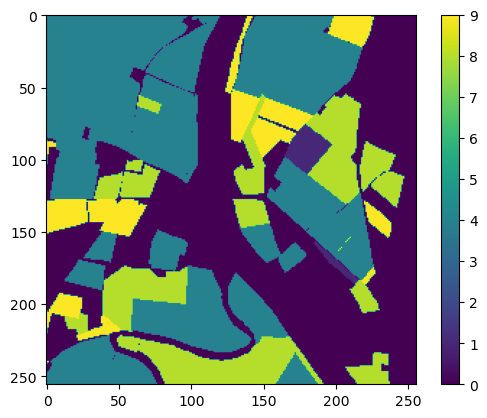

In [11]:
plt.imshow(label_splits[mas])
plt.colorbar()

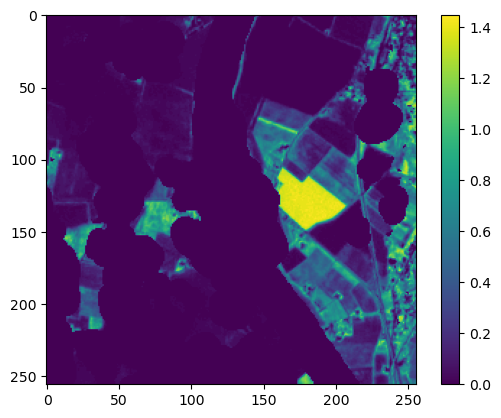

In [12]:
plt.imshow(image_splits[mas])
plt.colorbar()

In [13]:
#label_splits[label_splits==i]=i%10

In [14]:
print(label_splits.shape)
print(image_splits.shape)

(7000, 256, 256, 1)
(7000, 256, 256, 1)


In [15]:
total_classes = len(np.unique(label_splits))


In [16]:
label_splits = tf.constant(label_splits)

In [17]:
label_splits.shape

TensorShape([7000, 256, 256, 1])

In [18]:
import tensorflow as tf

# Example generator function
def _mask_batch_generator(data, batch_size):
    num_samples = data.shape[0]
    num_batches = num_samples // batch_size

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        batch_data = data[start_idx:end_idx]
        #print("batch_data.shape", batch_data.shape)
        # Convert batch_data to categorical matrix
        batch_categorical = tf.keras.utils.to_categorical(batch_data, num_classes=total_classes)
        #print("batch_categorical.shape", batch_categorical.shape)

        yield batch_categorical

# Example data
#input_data = tf.random.normal((50945, 256, 256, 1))  # Replace with your actual input data
#batch_size = 1000  # Set an appropriate batch size





In [19]:
# Iterate through the batches
batch_size = 1000
merged_tensor = None

for batch in _mask_batch_generator(label_splits, batch_size):
    # Process each batch as needed
    # ...

    # Concatenate the batch tensor to the merged tensor
    if merged_tensor is None:
        merged_tensor = batch
    else:
        merged_tensor = tf.concat([merged_tensor, batch], axis=0)

print(merged_tensor.shape)

(7000, 256, 256, 10)


In [20]:
#labels_categorical_dataset = to_categorical(label_splits, num_classes=total_classes)
labels_categorical_dataset = merged_tensor.numpy()


In [21]:
labels_categorical_dataset.shape

(7000, 256, 256, 10)

In [22]:
master_trianing_dataset = image_splits[:labels_categorical_dataset.shape[0]]

In [23]:
master_trianing_dataset.shape

(7000, 256, 256, 1)

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(master_trianing_dataset, labels_categorical_dataset, test_size=0.15, random_state=100)

In [26]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5950, 256, 256, 1)
(1050, 256, 256, 1)
(5950, 256, 256, 10)
(1050, 256, 256, 10)


In [27]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

In [28]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
1
10


# Deep learning part

In [29]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda
     

In [30]:
from keras import backend as K


In [31]:
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value


In [32]:
def multi_unet_model(n_classes=5, image_height=256, image_width=256, image_channels=1):

  inputs = Input((image_height, image_width, image_channels))

  source_input = inputs

  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.2)(c1)
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model

In [33]:
metrics = ["accuracy", jaccard_coef]


In [34]:

print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
1
10


In [35]:
def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes, 
                          image_height=image_height, 
                          image_width=image_width, 
                          image_channels=image_channels)

In [36]:
model = get_deep_learning_model()


In [37]:
# Uncomment below to see the model architecture
# model.get_config()

# Generating Loss function

In [38]:
weights = [1/total_classes for i in range(total_classes)]


In [39]:
#import segmentation_models as sm


In [40]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm


Segmentation Models: using `tf.keras` framework.


In [41]:
dice_loss = sm.losses.DiceLoss(class_weights = weights)


In [42]:
focal_loss = sm.losses.CategoricalFocalLoss()


In [43]:
'''dice_loss = sm.losses.DiceLoss(class_weights = weights)
dice_loss = sm.losses.DiceLoss(class_weights = weights)
total_loss = dice_loss + (1 * focal_loss)'''


'dice_loss = sm.losses.DiceLoss(class_weights = weights)\ndice_loss = sm.losses.DiceLoss(class_weights = weights)\ntotal_loss = dice_loss + (1 * focal_loss)'

In [44]:
dice_loss = sm.losses.DiceLoss(class_weights = weights)


In [45]:
total_loss = dice_loss + (1 * focal_loss)


In [46]:
import tensorflow as tf


In [47]:
tf.keras.backend.clear_session()


In [48]:
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)


In [49]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [50]:
# To visualize the model
from keras.utils.vis_utils import plot_model

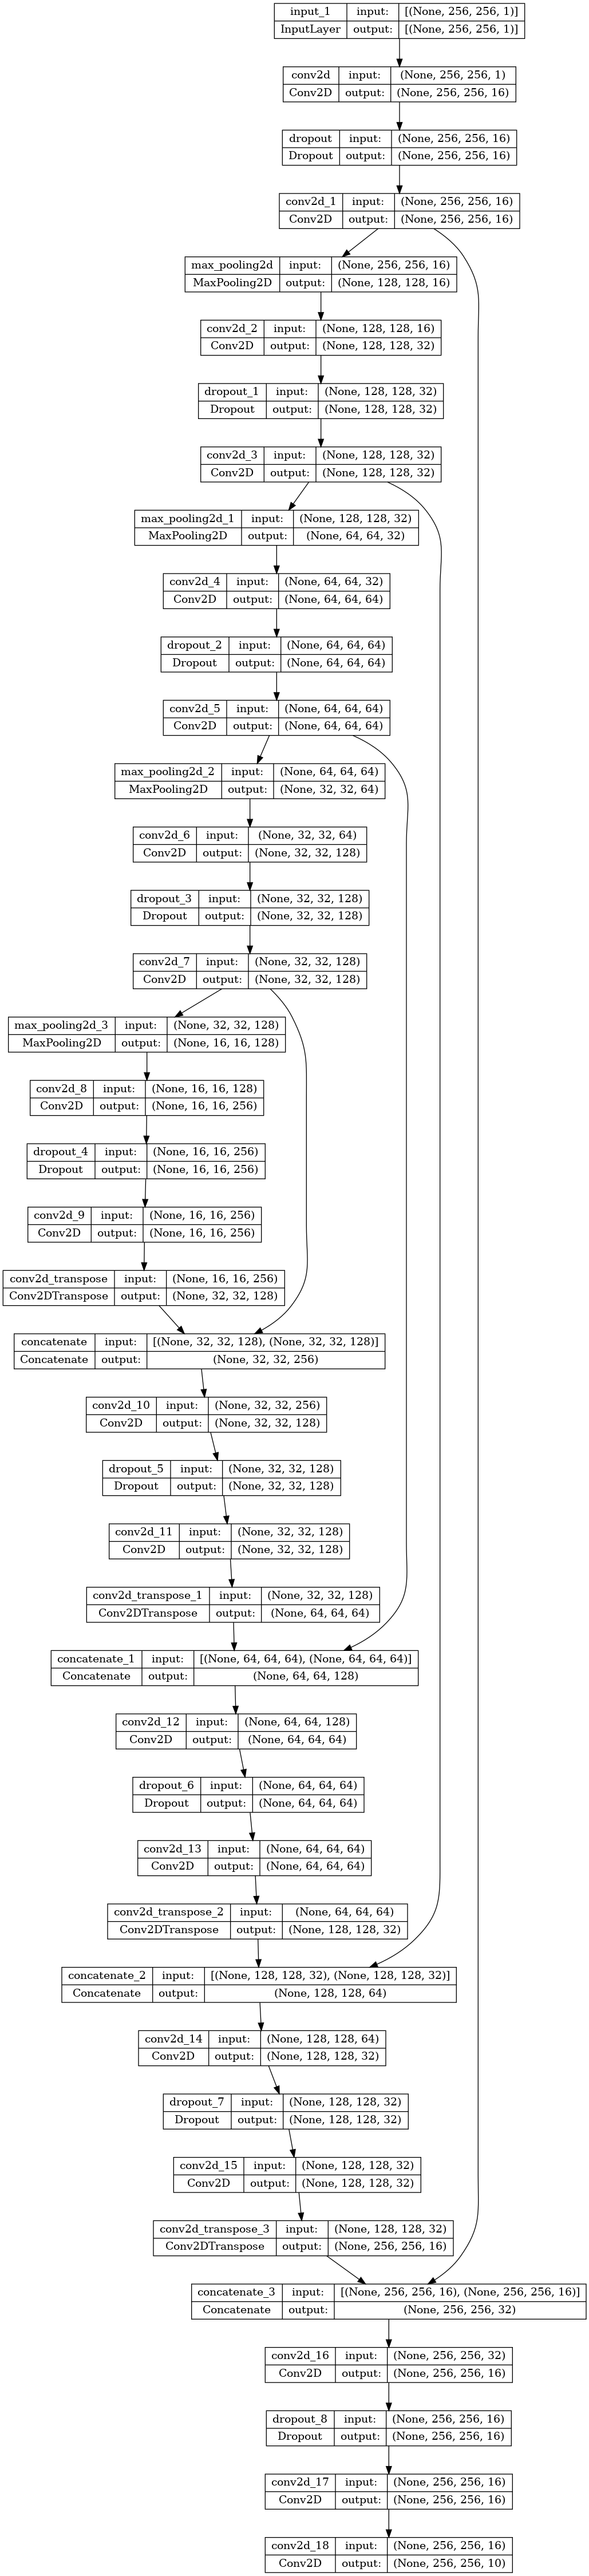

In [51]:
plot_model(model, to_file='satellite_model_plot.png', show_shapes=True, show_layer_names=True)

In [52]:
import keras
from IPython.display import clear_output
%matplotlib inline

In [53]:
class PlotLoss(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.jaccard_coef = []
        self.val_jaccard_coef = []
        self.fig = plt.figure()
        self.logs = []
    
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        #self.losses.append(logs.get("loss"))
        #self.val_losses.append(logs.get("val_loss"))

        self.jaccard_coef.append(logs.get("jaccard_coef"))
        self.val_jaccard_coef.append(logs.get("val_jaccard_coef"))

        self.i += 1

        clear_output(wait=True)
        #plt.plot(self.x, self.losses, label="loss")
        #plt.plot(self.x, self.val_losses, label="val_loss")

        plt.plot(self.x, self.jaccard_coef, label="jaccard_coef")
        plt.plot(self.x, self.val_jaccard_coef, label="val_jaccard_coef")

        plt.legend()
        plt.show();
    
plot_loss = PlotLoss()

In [54]:
# To get two plots
class PlotLossEx(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.jaccard_coef = []
        self.val_jaccard_coef = []
        self.fig = plt.figure()
        self.logs = []
    
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get("loss"))
        self.val_losses.append(logs.get("val_loss"))

        self.jaccard_coef.append(logs.get("jaccard_coef"))
        self.val_jaccard_coef.append(logs.get("val_jaccard_coef"))

        self.i += 1

        plt.figure(figsize=(14, 8))
        f, (graph1, graph2) = plt.subplots(1, 2, sharex=True)

        clear_output(wait=True)
        
        graph1.set_yscale('log')
        graph1.plot(self.x, self.losses, label="loss")
        graph1.plot(self.x, self.val_losses, label="val_loss")
        graph1.legend()

        graph2.set_yscale('log')
        graph2.plot(self.x, self.jaccard_coef, label="jaccard_coef")
        graph2.plot(self.x, self.val_jaccard_coef, label="val_jaccard_coef")

        graph2.legend()
        plt.show();
    
plot_loss = PlotLossEx()

<Figure size 1400x800 with 0 Axes>

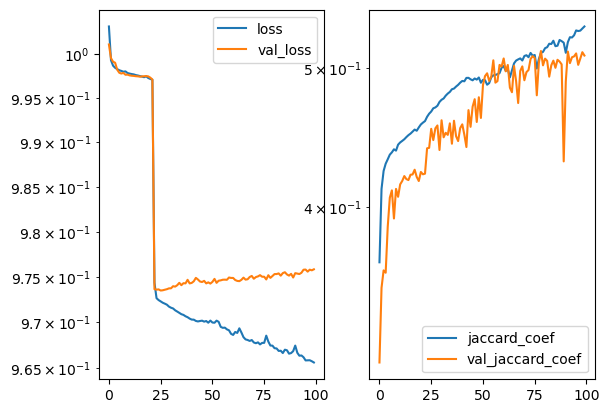

372/372 [==============================] - 16s 43ms/step - loss: 0.9656 - accuracy: 0.8245 - jaccard_coef: 0.5340 - val_loss: 0.9758 - val_accuracy: 0.7994 - val_jaccard_coef: 0.5097


In [55]:
# Training the model
#Two graph
model_history = model.fit(X_train, y_train,
                          batch_size=16,
                          verbose=1,
                          epochs=100,
                          validation_data=(X_test, y_test),
                          callbacks=[plot_loss],
                          shuffle=False)

In [57]:
'''
#One graph
model_history = model.fit(X_train, y_train,
                          batch_size=16,
                          verbose=1,
                          epochs=10,
                          validation_data=(X_test, y_test),
                          callbacks=[plot_loss],
                          shuffle=False)'''

'\n#One graph\nmodel_history = model.fit(X_train, y_train,\n                          batch_size=16,\n                          verbose=1,\n                          epochs=10,\n                          validation_data=(X_test, y_test),\n                          callbacks=[plot_loss],\n                          shuffle=False)'

In [56]:
history_a = model_history


In [57]:
history_a.history

{'loss': [1.0030711889266968,
  0.9992449879646301,
  0.9986286163330078,
  0.9983841776847839,
  0.9982379078865051,
  0.9981074333190918,
  0.9980319142341614,
  0.997939944267273,
  0.997979998588562,
  0.9977931976318359,
  0.9977297782897949,
  0.9976782202720642,
  0.9976375102996826,
  0.9975601434707642,
  0.9975135326385498,
  0.997447669506073,
  0.9973900318145752,
  0.997321367263794,
  0.9974209070205688,
  0.9972319602966309,
  0.9971252679824829,
  0.9970399737358093,
  0.9743708372116089,
  0.9726571440696716,
  0.9724467992782593,
  0.9723038673400879,
  0.9721555113792419,
  0.9720525741577148,
  0.9719403386116028,
  0.9717286229133606,
  0.9716047644615173,
  0.9715215563774109,
  0.9713208079338074,
  0.9711820483207703,
  0.9710392355918884,
  0.970892608165741,
  0.970815896987915,
  0.9706645607948303,
  0.9705609679222107,
  0.9704080820083618,
  0.9702988862991333,
  0.970291256904602,
  0.9701508283615112,
  0.9700959324836731,
  0.9701445698738098,
  0.97018

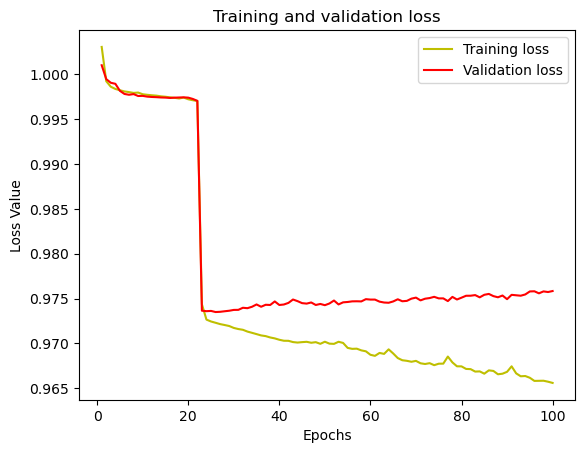

In [58]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')   
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()
plt.show()


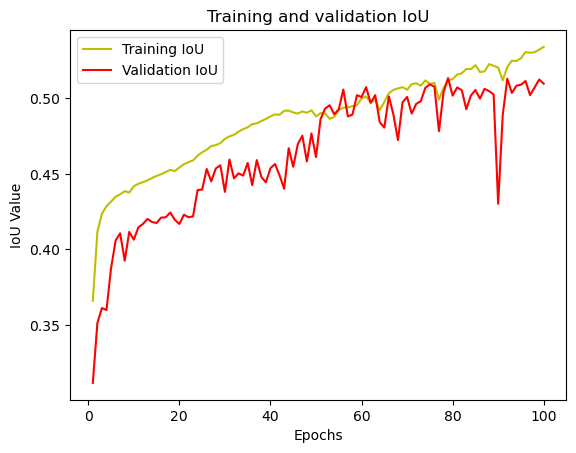

In [59]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']
epochs = range(1, len(jaccard_coef) + 1)

plt.plot(epochs, jaccard_coef, 'y', label='Training IoU')
plt.plot(epochs, val_jaccard_coef, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU Value')
plt.legend()
plt.show()


In [60]:
model_history.params

{'verbose': 1, 'epochs': 100, 'steps': 372}

In [61]:
# Saving the model

model.save('./saved_model/sat_stelar_image_segmentation_L1.h5')

In [62]:
# Loading the model


import keras.backend as K
import segmentation_models as sm

def dice_loss_plus_1focal_loss(y_true, y_pred):
    # Compute dice loss using the DiceLoss class from segmentation_models
    dice_loss = sm.losses.DiceLoss(class_weights=weights)(y_true, y_pred)

    # Compute focal loss using the CategoricalFocalLoss class from segmentation_models
    focal_loss = sm.losses.CategoricalFocalLoss()(y_true, y_pred)

    # Combine the dice loss and focal loss
    total_loss = dice_loss + (1 * focal_loss)

    return total_loss

In [63]:
import keras
from keras import models

# Register the custom loss function
keras.losses.dice_loss_plus_1focal_loss = dice_loss_plus_1focal_loss
keras.metrics.jaccard_coef = jaccard_coef
# Load the saved model
#model = models.load_model('./saved_model/sat_stelar_image_segmentation.h5')
model = models.load_model('./saved_model/sat_stelar_image_segmentation_L1.h5') # 10 classes 7000 sample size Unet convergence


# Comparing prediction results

##### using test images, using mask images and predicted result images

1/1 [==============================] - 0s 25ms/step


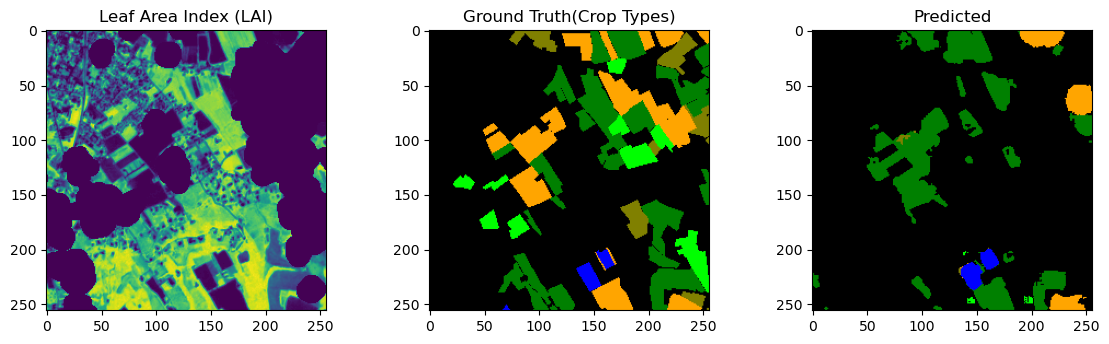

In [137]:
#X_test = X_train
#y_test = y_train

y_test_argmax = np.argmax(y_test, axis=3)
test_image_number = random.randint(0, len(X_test)-1)

test_image = X_test[test_image_number]
groud_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, axis=0)

prediction = (model.predict(test_image_input))
predicted_image = np.argmax(prediction, axis=-1)
predicted_image = predicted_image[0,:,:]





groud_truth_image = groud_truth_image
predicted_image = predicted_image

color_map = {
    0: [0, 0, 0],      # Black
    1: [0, 255, 0],      # Green
    2: [0, 0, 255],      # Blue
    3: [255, 255, 0],    # Yellow
    4: [255, 165, 0],    # Orange
    5: [255, 0, 255],    # Magenta
    6: [0, 255, 255],    # Cyan
    7: [128, 0, 128],    # Violet
    8: [128, 128, 0],    # Olive
    9: [0, 128, 0],      # Dark Green
    10: [128, 0, 0],     # Maroon
    11: [0, 0, 128],     # Navy
    12: [128, 128, 128], # Gray
    13: [0, 128, 128],   # Teal
    14: [255, 0, 0],      # Red
    15: [255, 255, 255], # White
    16: [192, 192, 192], # Silver
    17: [255, 0, 0],     # Red (Duplicate)
    18: [0, 255, 0],     # Green (Duplicate)
    19: [0, 0, 255],     # Blue (Duplicate)
    20: [255, 255, 0],   # Yellow (Duplicate)
    21: [255, 165, 0],   # Orange (Duplicate)
    22: [255, 0, 255],   # Magenta (Duplicate)
    23: [0, 255, 255],   # Cyan (Duplicate)
    24: [128, 0, 128],   # Violet (Duplicate)
    25: [128, 128, 0],   # Olive (Duplicate)
    26: [0, 128, 0],     # Dark Green (Duplicate)
    27: [128, 0, 0],     # Maroon (Duplicate)
    28: [0, 0, 128],     # Navy (Duplicate)
    29: [128, 128, 128], # Gray (Duplicate)
    30: [0, 128, 128],   # Teal (Duplicate)
    31: [0, 0, 0],       # Black (Duplicate)
    32: [255, 255, 255], # White (Duplicate)
    33: [192, 192, 192], # Silver (Duplicate)
    34: [255, 0, 0],     # Red (Duplicate)
    35: [0, 255, 0],     # Green (Duplicate)
    36: [0, 0, 255],     # Blue (Duplicate)
    37: [255, 255, 0],   # Yellow (Duplicate)
    38: [255, 165, 0],   # Orange (Duplicate)
    39: [255, 0, 255],   # Magenta (Duplicate)
    40: [0, 128, 255]    # Sky Blue (New Color)
}


# Create color plot
groud_truth_color_image = np.zeros(groud_truth_image.shape + (3,), dtype=np.uint8)
predicted_color_image = np.zeros(predicted_image.shape + (3,), dtype=np.uint8)
for i in range(groud_truth_image.shape[0]):
    for j in range(groud_truth_image.shape[1]):
        segment_id_gt = groud_truth_image[i, j]
        segment_id_pd = predicted_image[i, j]
        groud_truth_color_image[i, j] = color_map[segment_id_gt]
        predicted_color_image[i, j] = color_map[segment_id_pd]





# Put all the 3 images together and display
plt.figure(figsize=(14, 8))
plt.subplot(231)
plt.title('Leaf Area Index (LAI)')
test_image[test_image<0] = 0
plt.imshow(test_image)
plt.subplot(232)
plt.title('Ground Truth(Crop Types)')
#plt.imshow(groud_truth_image)
plt.imshow(groud_truth_color_image)
plt.subplot(233)
plt.title('Predicted')
#plt.imshow(predicted_image)
plt.imshow(predicted_color_image)

In [ ]:
#plots

# Class Imbalance Analysis

In [138]:
# Evaluation

X_train, X_test, y_train, y_test = train_test_split(master_trianing_dataset, labels_categorical_dataset, test_size=0.15, random_state=100)

In [139]:
y_test.shape, y_test.shape

((1050, 256, 256, 10), (1050, 256, 256, 10))

In [140]:
y_test_argmax = np.argmax(y_test, axis=3)


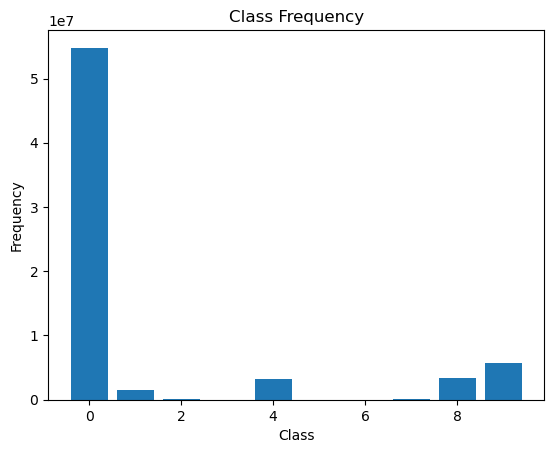

In [141]:
# get unique values in the y_test_argmax set and their frequency and plot the histogram
unique, counts = np.unique(y_test_argmax, return_counts=True)
plt.bar(unique, counts)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()




In [142]:
unique, counts = np.unique(y_test_argmax, return_counts=True)
dict(zip(unique, counts))


{0: 54793420,
 1: 1480403,
 2: 83369,
 3: 5452,
 4: 3151948,
 5: 8,
 6: 33352,
 7: 34880,
 8: 3456601,
 9: 5773367}

In [143]:
unique, counts

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([54793420,  1480403,    83369,     5452,  3151948,        8,
           33352,    34880,  3456601,  5773367]))

# Segmentation Quality Measurements

## Intersection over Union (IoU)

In [144]:
from sklearn.metrics import jaccard_score, f1_score, accuracy_score

In [145]:
test_image = X_test[test_image_number]
test_image.shape

(256, 256, 1)

In [146]:
X_test.shape

(1050, 256, 256, 1)

In [147]:
len(X_test)

1050

In [148]:
no_classes = 10
crop = 0

all_class_iou = []
for crop in range(no_classes):
    all_iou = []
    for test_image_number in range(len(X_test)-1040):

        test_image = X_test[test_image_number]
        y_test_argmax = np.argmax(y_test, axis=3)
        groud_truth_image = y_test_argmax[test_image_number]
        test_image_input = np.expand_dims(test_image, axis=0)
        prediction = (model.predict(test_image_input))
        predicted_image = np.argmax(prediction, axis=-1)
        predicted_image = predicted_image[0,:,:]
        img_true=np.array(groud_truth_image).ravel()
        img_pred=np.array(predicted_image).ravel()

        for i in range(no_classes):
            if(i==crop):
                img_true[img_true==i]=100
                img_pred[img_pred==i]=100
            else:
                img_true[img_true==i]=0
                img_pred[img_pred==i]=0


        iou = jaccard_score(img_true, img_pred, average='macro')

        print(iou)

        all_iou.append(iou)
    all_class_iou.append(all_iou)

1/1 [==============================] - 0s 24ms/step
0.46343231201171875
1/1 [==============================] - 0s 24ms/step
0.49985504150390625
1/1 [==============================] - 0s 25ms/step
0.5847284423878077
1/1 [==============================] - 0s 24ms/step
0.7361732977441737
1/1 [==============================] - 0s 24ms/step
0.49752044677734375
1/1 [==============================] - 0s 24ms/step
0.498382568359375
1/1 [==============================] - 0s 24ms/step
0.42925060467117093
1/1 [==============================] - 0s 24ms/step
0.8002382725795785
1/1 [==============================] - 0s 24ms/step
0.4103851318359375
1/1 [==============================] - 0s 24ms/step
0.5960062810446196
1/1 [==============================] - 0s 25ms/step
0.498809814453125
1/1 [==============================] - 0s 24ms/step
1.0
1/1 [==============================] - 0s 24ms/step
0.49456024169921875
1/1 [==============================] - 0s 24ms/step
0.4999847412109375
1/1 [=============

In [ ]:
len(all_class_iou[0])

10

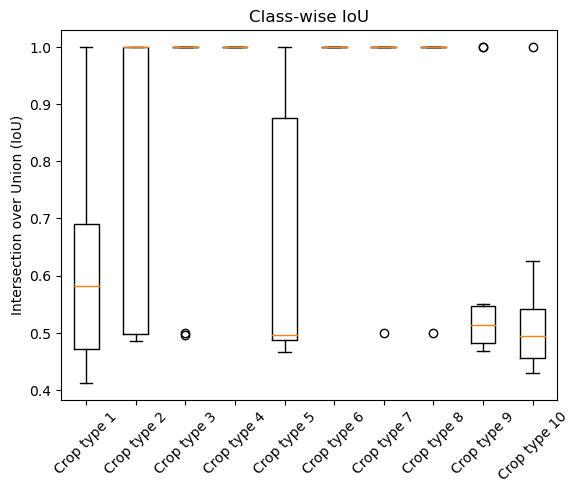

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(all_class_iou)
ax.set_xticklabels(['Crop type 1', 'Crop type 2', 'Crop type 3', 'Crop type 4', 'Crop type 5', 'Crop type 6', 'Crop type 7', 'Crop type 8', 'Crop type 9', 'Crop type 10'], rotation=45)

ax.set_ylabel('Intersection over Union (IoU)')

ax.set_title('Class-wise IoU')

plt.show()


In [93]:
#f1_sc = f1_score(img_true.flatten(), img_true.flatten(), zero_division=1)
f1_sc = f1_score(img_true.flatten(), img_true.flatten(), labels=[0, 100], pos_label=100, average='binary', zero_division=1)


# F1 Score

In [94]:
#dice = f1_score(img_true.flatten(), img_pred.flatten(), zero_division=1)
#dice


no_classes = 10
#crop = 0

all_class_f1_sc = []
for crop in range(no_classes):
    all_f1_sc = []
    for test_image_number in range(len(X_test)-1040):

        test_image = X_test[test_image_number]
        y_test_argmax = np.argmax(y_test, axis=3)
        groud_truth_image = y_test_argmax[test_image_number]
        test_image_input = np.expand_dims(test_image, axis=0)
        prediction = (model.predict(test_image_input))
        predicted_image = np.argmax(prediction, axis=-1)
        predicted_image = predicted_image[0,:,:]
        img_true=np.array(groud_truth_image).ravel()
        img_pred=np.array(predicted_image).ravel()

        for i in range(no_classes):
            if(i==crop):
                img_true[img_true==i]=100
                img_pred[img_pred==i]=100
            else:
                img_true[img_true==i]=0
                img_pred[img_pred==i]=0

        f1_sc = f1_score(img_true.flatten(), img_pred.flatten(), labels=[0, 100], pos_label=100, average='binary', zero_division=1)
        print(f1_sc)
        all_f1_sc.append(f1_sc)
    all_class_f1_sc.append(all_f1_sc)

1/1 [==============================] - 0s 24ms/step
0.9620443620871245
1/1 [==============================] - 0s 24ms/step
1.0
1/1 [==============================] - 0s 24ms/step
0.9807843879063022
1/1 [==============================] - 0s 24ms/step
0.8812574546227518
1/1 [==============================] - 0s 24ms/step
0.9975142833105157
1/1 [==============================] - 0s 25ms/step
0.9936934719744048
1/1 [==============================] - 0s 24ms/step
0.9163751829525439
1/1 [==============================] - 0s 24ms/step
0.9882056346396255
1/1 [==============================] - 0s 24ms/step
0.9040802675585284
1/1 [==============================] - 0s 25ms/step
0.7674711130612842
1/1 [==============================] - 0s 24ms/step
0.0
1/1 [==============================] - 0s 24ms/step
1.0
1/1 [==============================] - 0s 24ms/step
0.0
1/1 [==============================] - 0s 24ms/step
1.0
1/1 [==============================] - 0s 24ms/step
1.0
1/1 [====================

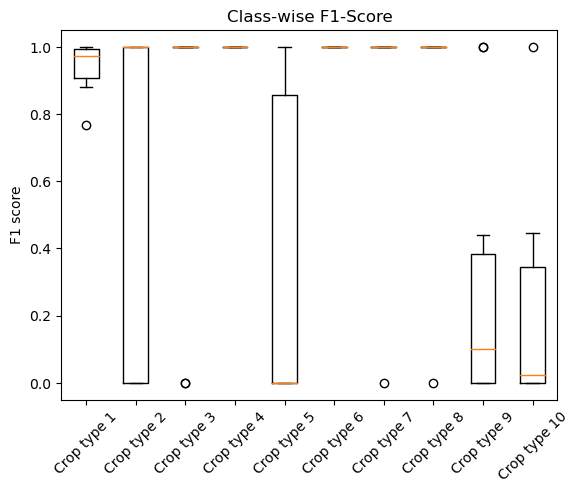

In [95]:
fig, ax = plt.subplots()
ax.boxplot(all_class_f1_sc)
ax.set_xticklabels(['Crop type 1', 'Crop type 2', 'Crop type 3', 'Crop type 4', 'Crop type 5', 'Crop type 6', 'Crop type 7', 'Crop type 8', 'Crop type 9', 'Crop type 10'], rotation=45)

ax.set_ylabel('F1 score')

ax.set_title('Class-wise F1-Score')

plt.show()


# Accuracy

